In [1]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [2]:
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.special import lpmv
import pyshtools as pysh
from pyshtools.legendre import legendre_lm
from skimage.io import imread

In [3]:
from plotting import format_plot, save_plot

# Angle-based thermal radiation

5.670374419


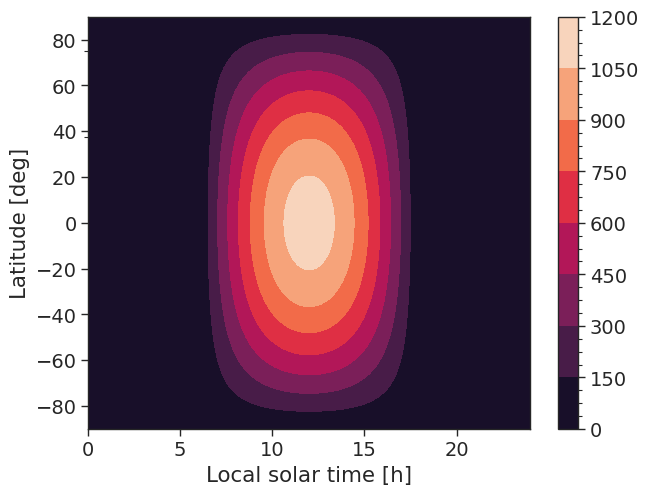

In [4]:
def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    def exitance(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(375 * cosphi**(1/4), 100)
        return sigma * T**4
    
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    print(exitance(np.pi / 2, np.pi))
    
    exitances = np.vectorize(exitance)(polars, azimuths)
    plt.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances)
    plt.colorbar()
    plt.xlabel("Local solar time [h]")
    plt.ylabel("Latitude [deg]")
    
    format_plot()
    
plot_thermal_lemoine()

# SH albedo distribution

$$
a = \sum_{l=0}^\infty \sum_{m=0}^l ...
$$
* $n=l$: degree
* $m$: order

In [5]:
def read_coeffs():
   with open("files/DLAM-1.txt") as f:
       lines = f.readlines()
   lines = [line[8:-1] for line in lines[2:]]
   
   cos_coeffs = np.zeros((16, 16))
   sin_coeffs = np.zeros((16, 16))

   for line in lines:
      l = int(line[:2])
      m = int(line[2:4])
      
      cos_coeffs[l, m] = float(line[20:36].replace("D", "E"))
      sin_coeffs[l, m] = float(line[37:].replace("D", "E"))
   
   # sin_coeffs, cos_coeffs = cos_coeffs, sin_coeffs
   return cos_coeffs, sin_coeffs

cos_coeffs, sin_coeffs = read_coeffs()

In [6]:
# with np.printoptions(precision=1, linewidth=1000):
#     print("rows = degree, cols = order")
#     print(cos_coeffs)

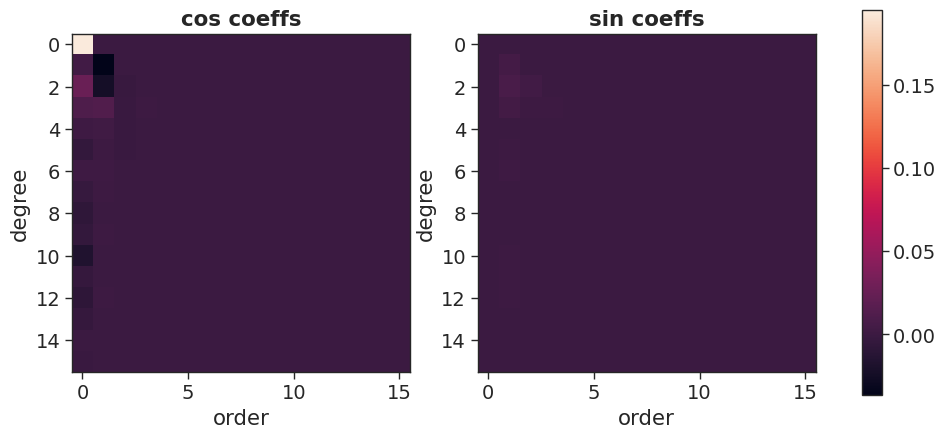

In [7]:
def plot_coeffs():
    vmin = min(cos_coeffs.min(), sin_coeffs.min())
    vmax = max(cos_coeffs.max(), sin_coeffs.max())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(cos_coeffs, vmin=vmin, vmax=vmax)
    ax1.set_title("cos coeffs")
    ax1.set_xlabel("order")
    ax1.set_ylabel("degree")

    im = ax2.imshow(sin_coeffs, vmin=vmin, vmax=vmax)
    ax2.set_title("sin coeffs")
    ax2.set_xlabel("order")
    ax2.set_ylabel("degree")

    plt.colorbar(im, ax=[ax1, ax2])

plot_coeffs()

In [8]:
def dlam1(lat, lon):
   lat = np.radians(lat)
   lon = np.radians(lon)
   sin_lat = np.sin(lat)

   a = 0
   for l in range(0, 16):
      for m in range(0, l+1):
         # (-1)^m to remove Condon-Shortley phase of lpmv
         Pnm = (-1)**m * lpmv(m, l, sin_lat)
         a += (
            cos_coeffs[l, m] * np.cos(m * lon) + sin_coeffs[l, m] * np.sin(m * lon)
         ) * Pnm
   return a

dlam1(-90, 30)

0.19819844081000004

In [9]:
def generate_albedo_map_manual():
   step = 1
   lats = range(-90, 90, step)
   lons = range(-180, 180, step)

   albedo_map = np.empty((180, 360))
   for lat, lon in product(lats, lons):
      if np.isnan(dlam1(lat, lon)):
         print(lat, lon)
      albedo_map[lat + 90, lon + 180] = dlam1(lat, lon)

   # Flip latitude
   albedo_map = np.flipud(albedo_map[::step, ::step])

   return albedo_map

albedo_map_manual = generate_albedo_map_manual()

In [10]:
def plot_albedo_map(albedo_map):
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
    ax.set_title(f"Albedo map (min = {albedo_map.min():.2f}, max = {albedo_map.max():.2f})")

    ax.imshow(albedo_map, cmap="gray")
    ax.set_yticks(range(0, 181, 30), range(-90, 91, 30))
    ax.set_xlabel("Longitude [°]")
    ax.set_ylabel("Latitude [°]")
    ax.set_xticks(range(0, 361, 30), range(-180, 181, 30))

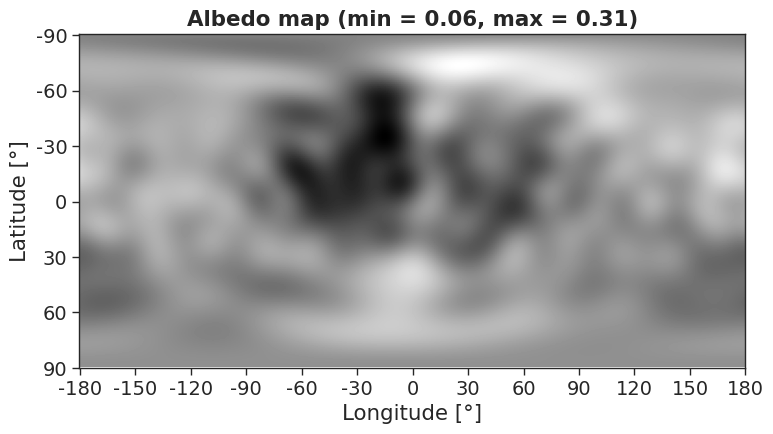

In [11]:
plot_albedo_map(albedo_map_manual)

In [12]:
def generate_albedo_map_shtools():
    sh = pysh.SHCoeffs.from_array(np.stack([cos_coeffs, sin_coeffs]), normalization="unnorm")

    lats = np.arange(90, -90, -1)
    lons = np.arange(-180, 180)
    coords_lat, coords_lon = np.meshgrid(lats, lons, indexing="ij")
    albedo_map = sh.expand(lat=coords_lat, lon=coords_lon)

    # grid = sh.expand(grid="DH2")
    # albedo_map = grid.data
    # lats = albedo_map.lats()
    # lons = albedo_map.lons()

    return albedo_map

albedo_map_shtools = generate_albedo_map_shtools()

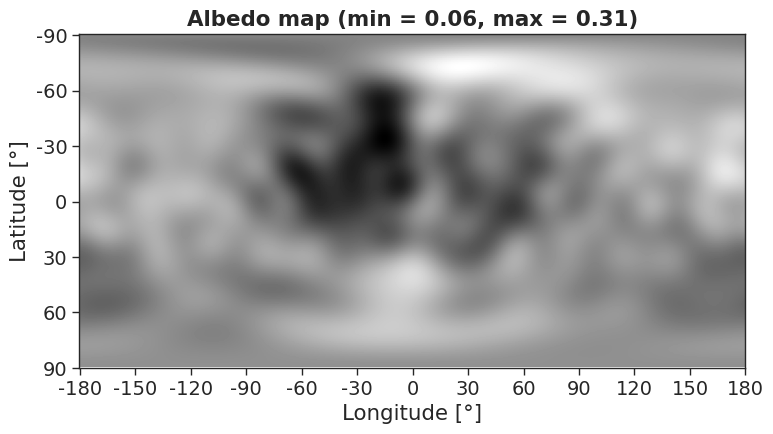

In [13]:
plot_albedo_map(albedo_map_shtools)

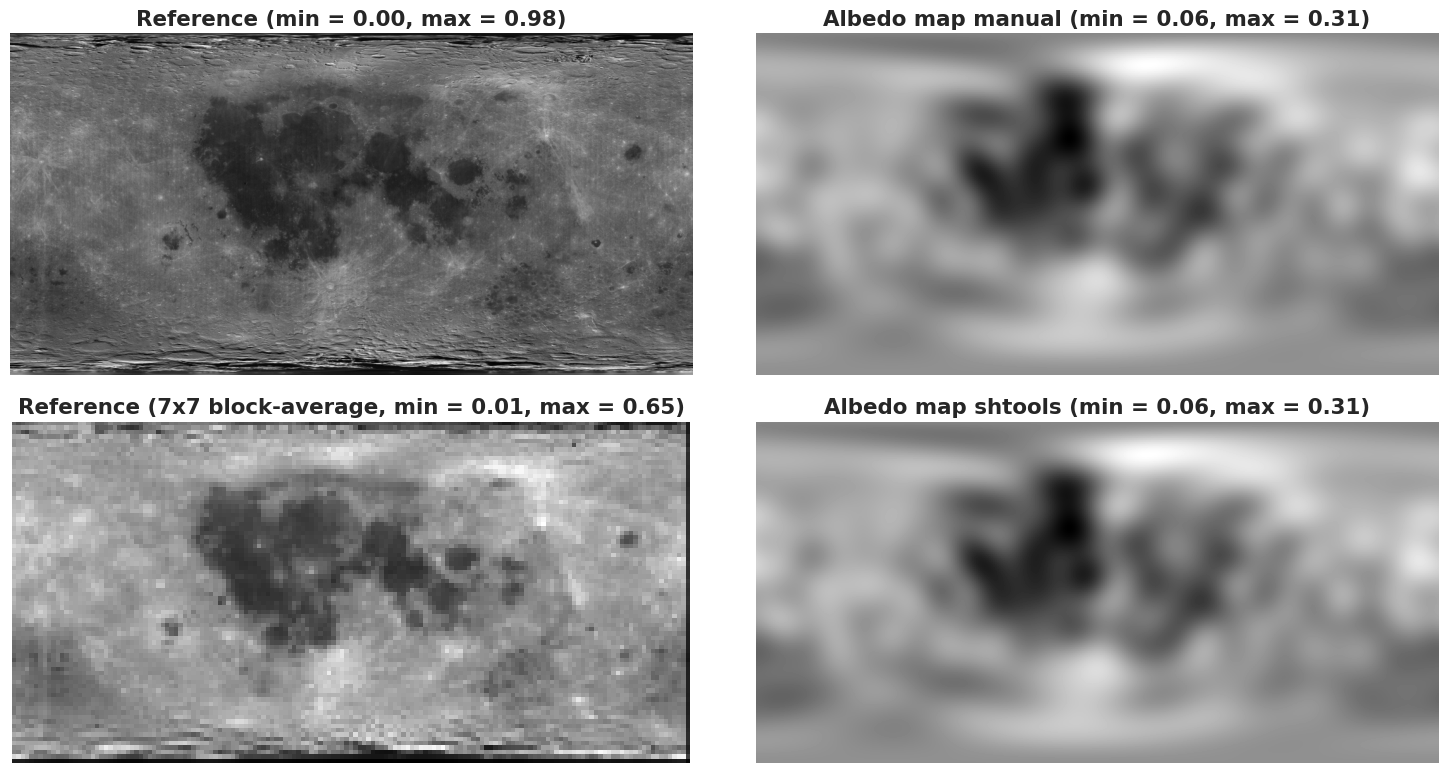

In [14]:
def plot_blurred_reference(albedo_map_manual, albedo_map_shtools):
    from skimage.filters.rank import mean
    from skimage.morphology import square
    from skimage.measure import block_reduce

    ref = imread("files/albedo.tiff")
    # ref_blur = mean(ref, square(7))
    ref_blur = block_reduce(ref, 7, np.mean)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), tight_layout=True)

    ax1.imshow(ref, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Reference (min = {ref.min()/255:.2f}, max = {ref.max()/255:.2f})")

    ax2.imshow(albedo_map_manual, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Albedo map manual (min = {albedo_map_manual.min():.2f}, max = {albedo_map_manual.max():.2f})")

    ax3.imshow(ref_blur, cmap="gray")
    ax3.axis("off")
    ax3.set_title(f"Reference (7x7 block-average, min = {ref_blur.min()/255:.2f}, max = {ref_blur.max()/255:.2f})")

    ax4.imshow(albedo_map_shtools, cmap="gray")
    ax4.axis("off")
    ax4.set_title(f"Albedo map shtools (min = {albedo_map_shtools.min():.2f}, max = {albedo_map_shtools.max():.2f})")

plot_blurred_reference(albedo_map_manual, albedo_map_shtools)